In [333]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import os

## Part 1: knowing how this DF was strutured 

In [334]:
FILEFOLDER = os.path.abspath("decision_science_dataset.csv")
df = pd.read_csv(FILEFOLDER).copy()
full_df = df

In [335]:
# Show how this DF was strutured
print(df.shape)
df.info()

(4709, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4709 entries, 0 to 4708
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tag1       4709 non-null   float64
 1   tag2       4709 non-null   float64
 2   tag3       4709 non-null   float64
 3   tag4       4709 non-null   float64
 4   tag5       4709 non-null   float64
 5   tag6       4709 non-null   float64
 6   tag7       4709 non-null   float64
 7   tag8       4709 non-null   float64
 8   tag9_resp  4709 non-null   float64
dtypes: float64(9)
memory usage: 331.2 KB


In [336]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

tag1        tag2        tag3        tag4        tag5        tag6  \
count  4709.00000  4709.00000  4709.00000  4709.00000  4709.00000  4709.00000   
mean      0.00000    -0.00000    -0.00000    -0.00000     0.12680     0.07136   
std       1.00011     1.00011     1.00011     1.00011     0.69163     0.70760   
min      -1.63556    -7.03781    -1.55994    -2.73873    -1.00000    -1.00000   
25%      -0.86153    -0.39768    -0.51768    -0.00020    -0.51971    -0.62277   
50%      -0.01286     0.56868     0.07634    -0.00020     0.25096     0.10206   
75%       0.78926     0.60238     0.34298    -0.00020     0.79467     0.79766   
max       2.20686     0.92032    55.00408     4.79221     1.00000     1.00000   

             tag7        tag8   tag9_resp  
count  4709.00000  4709.00000  4709.00000  
mean      0.16629    -0.08556    -0.00000  
std       0.66088     0.72696     1.00011  
min      -1.00000    -1.00000    -2.01734  
25%      -0.41406    -0.82236    -0.77384  
50%       0.25415    -0.17769    -0.24241  
75%       0.80547     0.64177     0.62672  
max       1.00000     1.00000     5.81735

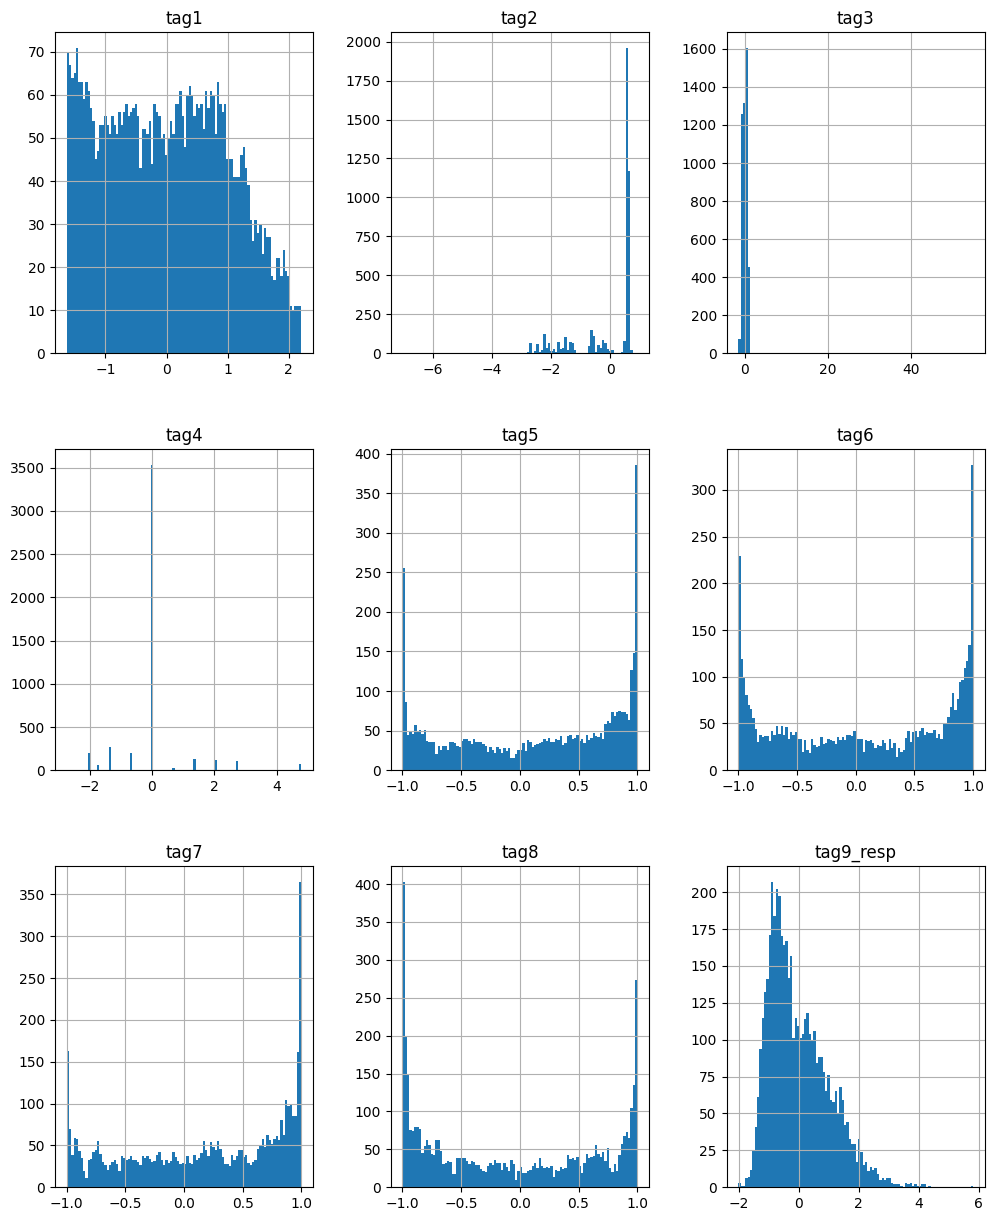

In [337]:
# #showing the histogram for all columns
df.hist(bins=100, figsize=(12,15))
plt.show()

### Data breakdown:
- **tags 1** : is amost an uniform distribution
- **tags 2-4**: we need to transform this beacuse, of probability outliers in this features
- **tags 5-8**: this data sounds like non-symmetric bimodal distribution, with two modes. we will use k-means to identify patterns 
- **tag response**: are right skewed negatively

## Part 2: investigating all features individually

In [338]:
def outliers(df, feature):
    Q3 = df[feature].quantile(0.75)
    Q1 = df[feature].quantile(0.25)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    outliers_sup = (df[feature] > upper_limit).sum()
    outliers_inf = (df[feature] < lower_limit).sum()

    percentage_outliers_sup = (outliers_sup / len(df[feature])) * 100
    percentage_outliers_inf = (outliers_inf / len(df[feature])) * 100

    print(f'Outliers superiors from columns {feature}: {outliers_sup} ({percentage_outliers_sup:.2f}%)')
    print(f'Outliers inferiors from columns {feature}: {outliers_inf} ({percentage_outliers_inf:.2f}%)')


In [339]:
for feature in df.columns:
    outliers(df,feature)

Outliers superiors from columns tag1: 0 (0.00%)
Outliers inferiors from columns tag1: 0 (0.00%)
Outliers superiors from columns tag2: 0 (0.00%)
Outliers inferiors from columns tag2: 429 (9.11%)
Outliers superiors from columns tag3: 4 (0.08%)
Outliers inferiors from columns tag3: 0 (0.00%)
Outliers superiors from columns tag4: 441 (9.37%)
Outliers inferiors from columns tag4: 734 (15.59%)
Outliers superiors from columns tag5: 0 (0.00%)
Outliers inferiors from columns tag5: 0 (0.00%)
Outliers superiors from columns tag6: 0 (0.00%)
Outliers inferiors from columns tag6: 0 (0.00%)
Outliers superiors from columns tag7: 0 (0.00%)
Outliers inferiors from columns tag7: 0 (0.00%)
Outliers superiors from columns tag8: 0 (0.00%)
Outliers inferiors from columns tag8: 0 (0.00%)
Outliers superiors from columns tag9_resp: 55 (1.17%)
Outliers inferiors from columns tag9_resp: 0 (0.00%)


as we can see, the most feature with outliers are tag4. So we need to start investigating it

In [340]:
df.tag4.value_counts()

tag4
-0.000204    3534
-1.369465     269
-2.054095     197
-0.684834     195
 1.369056     134
 2.053687     113
 2.738317     102
 4.792208      67
-1.711780      57
 0.684426      20
-2.738725       5
-2.305044       1
 1.137652       1
-0.260854       1
-1.963356       1
 0.449406       1
 2.559519       1
-1.990895       1
-1.652869       1
-0.684578       1
 0.580194       1
-1.511704       1
-1.756158       1
-0.778686       1
-2.189657       1
-1.010312       1
 0.354359       1
Name: count, dtype: int64

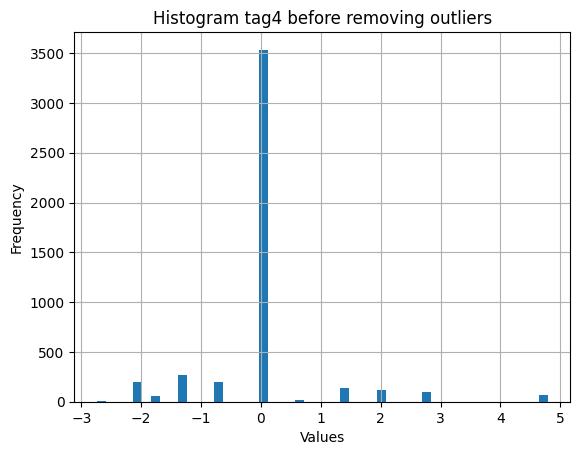

In [341]:
df.tag4.hist(bins=50)
plt.title('Histogram tag4 before removing outliers')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

the tag4 feature has many high-frequency values, so we need to eliminate the low-frequency values improve our power of prediction

In [342]:
# Eliminating tag4 values with frequency less than 100 

df = df[df['tag4'].map(df['tag4'].value_counts()) > 100]
percentage_of_drop_values = (1 - len(df)/len(full_df)) * 100
print(f'with this, we eliminate {percentage_of_drop_values:.2f}% of values')


with this, we eliminate 3.50% of values


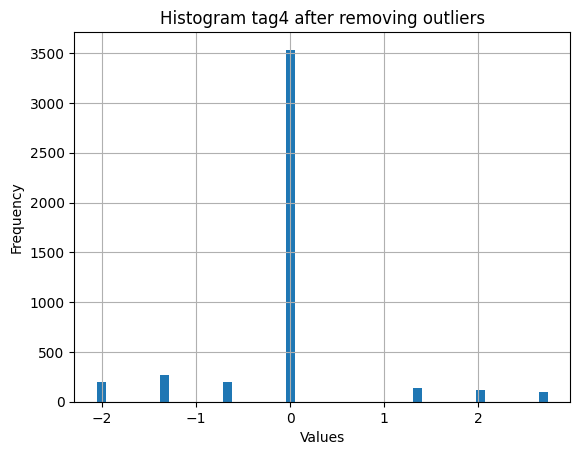

In [343]:
df.tag4.hist(bins=50)
plt.title('Histogram tag4 after removing outliers')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Lets check-out tags with outliers: tag2, tag3, tag9_resp

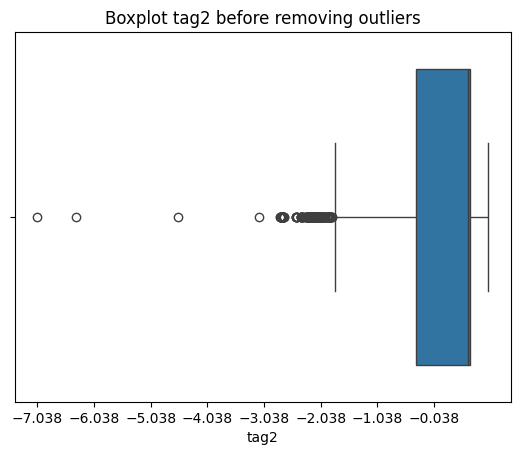

In [344]:
sns.boxplot(x=df['tag2'], orient='h')
plt.xticks(np.arange(df['tag2'].min(), df['tag2'].max()))
plt.title('Boxplot tag2 before removing outliers')
plt.show()

basing on this graph above, we will remove lowers than 3

In [345]:
df = df[df['tag2'] > -3]
percentage_of_drop_values = (1 - len(df)/len(full_df)) * 100
print(f'with this, we eliminate {percentage_of_drop_values:.2f}% of values')
outliers(df,'tag2')


with this, we eliminate 3.59% of values
Outliers superiors from columns tag2: 0 (0.00%)
Outliers inferiors from columns tag2: 384 (8.46%)


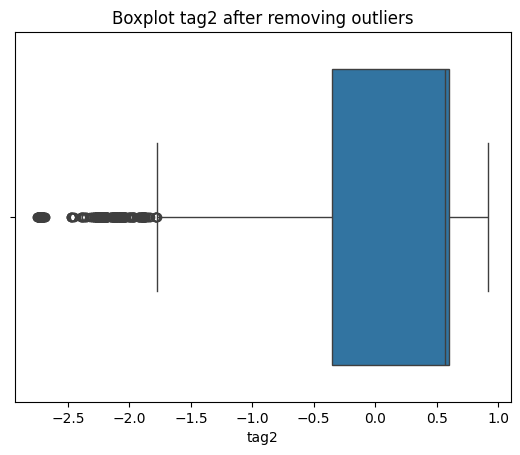

In [346]:
sns.boxplot(x=df['tag2'], orient='h')
plt.title('Boxplot tag2 after removing outliers')
plt.show()

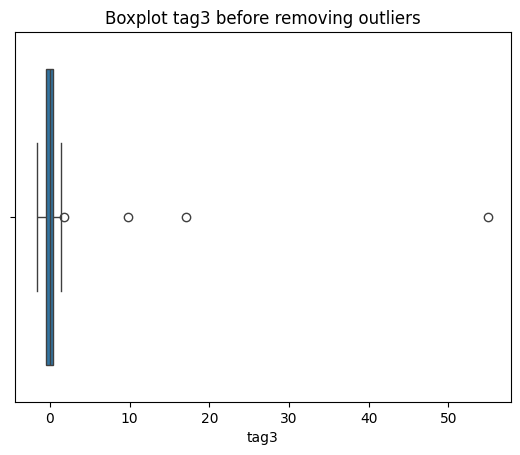

In [347]:
sns.boxplot(x=df['tag3'], orient='h')
plt.title('Boxplot tag3 before removing outliers')
plt.show()

lets remove outliers with outliers function

In [348]:
def remove_outliers(df, feature):
    Q3 = df[feature].quantile(0.75)
    Q1 = df[feature].quantile(0.25)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    old_df = df
    df = df[df[feature] < upper_limit]
    df = df[df[feature] > lower_limit]

    percentage_of_drop_values = (1 - len(df)/len(old_df)) * 100
    print(f'with this, we eliminate {percentage_of_drop_values:.2f}% of values')
    return df
    


In [349]:
df = remove_outliers(df, 'tag3')    

with this, we eliminate 0.09% of values


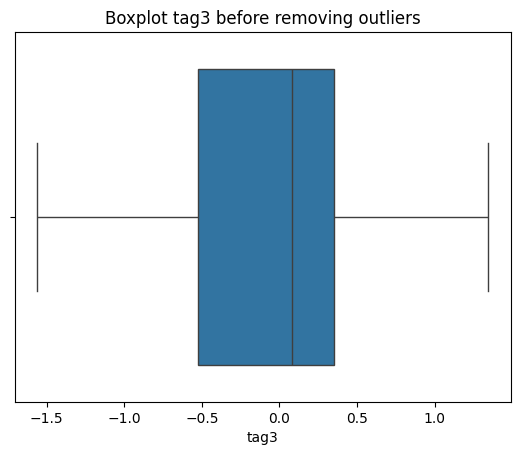

In [350]:
sns.boxplot(x=df['tag3'], orient='h')
plt.title('Boxplot tag3 before removing outliers')
plt.show()

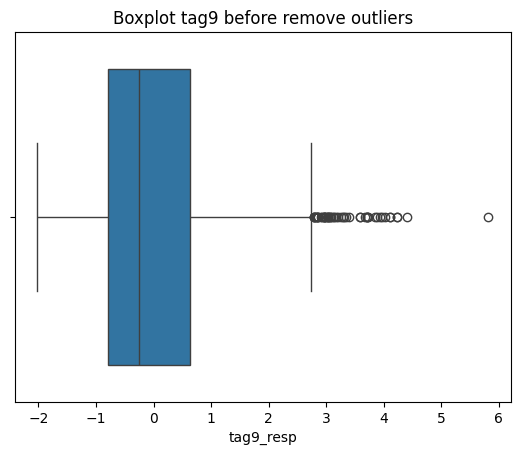

In [351]:
sns.boxplot(x=df['tag9_resp'], orient='h')
plt.title('Boxplot tag9 before remove outliers')
plt.show()

In [352]:
df = remove_outliers(df, 'tag9_resp')

with this, we eliminate 1.10% of values


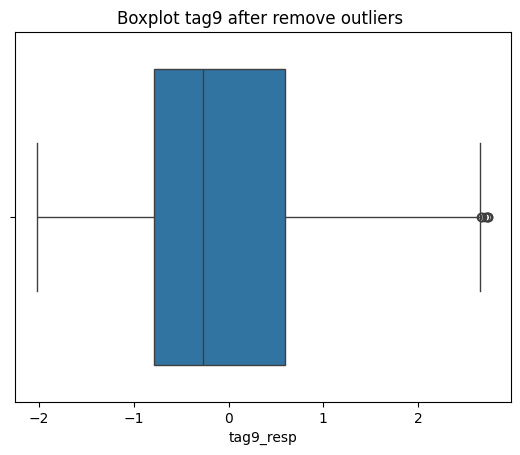

In [353]:
sns.boxplot(x=df['tag9_resp'], orient='h')
plt.title('Boxplot tag9 after remove outliers ')
plt.show()

In [354]:
print(f'we have {len(df) /len(full_df) * 100:.2f}% from initial dataset for predictions')

we have 95.26% from initial dataset for predictions


Try to get insights for the correlation between variables

In [355]:
from scipy import stats

In [356]:
#Pearson correlation 
df.corr().style.background_gradient(axis=None)

In [357]:
X = df.drop('tag9_resp', axis = 1)
y = df.tag9_resp
pd.DataFrame(
    [stats.pearsonr(X[col], y) for col in X.columns],
    columns=["Corr. Pearson", "p-value"],
    index=X.columns
).round(4)

Corr. Pearson  p-value
tag1         0.6996   0.0000
tag2         0.4454   0.0000
tag3        -0.0477   0.0014
tag4         0.2519   0.0000
tag5         0.0143   0.3393
tag6         0.0101   0.4996
tag7        -0.0625   0.0000
tag8        -0.0299   0.0452

analysing the p-value, we suspect that the bimodal variable will bias our predictions. So let`s deal with it 

## Part 3: dealing with bimodal data

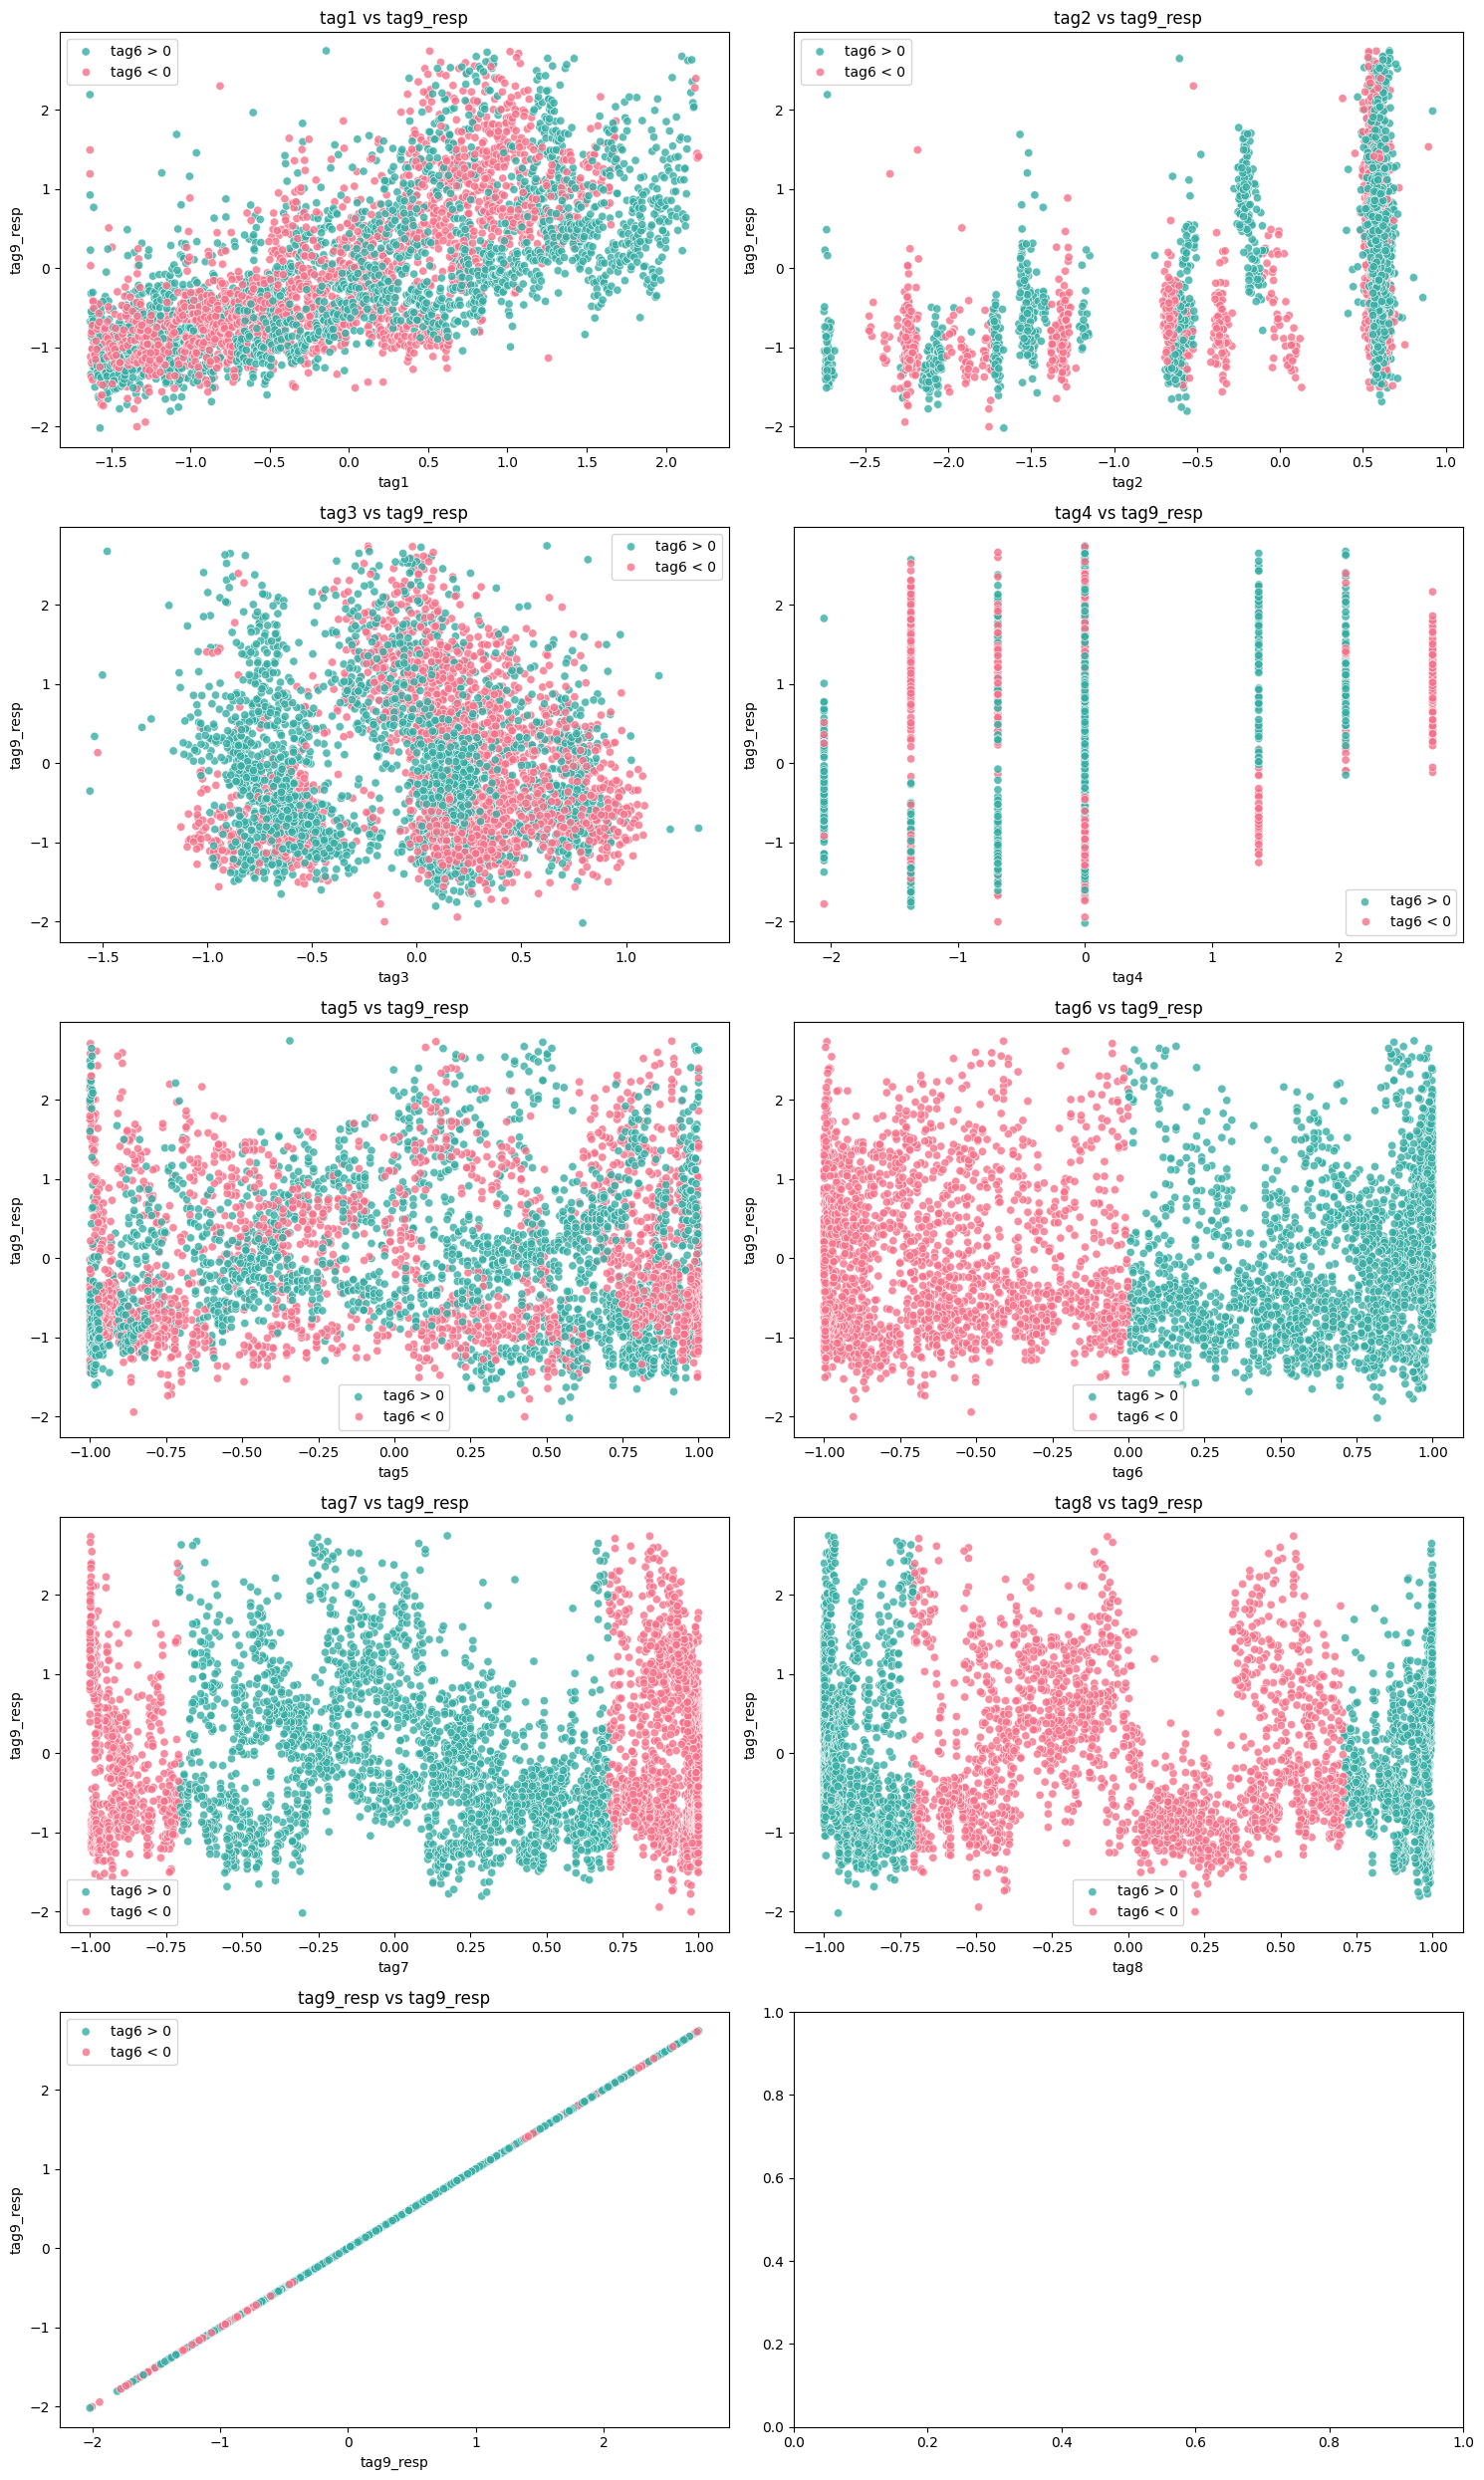

In [358]:
feature_columns = df.columns

# Set up the subplot grid
num_plots = len(feature_columns)
num_cols = 2  # You can adjust the number of columns based on your preference
num_rows = (num_plots - 1) // num_cols + 1

# Create a new figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Define a color palette
cluster_colors = sns.color_palette("husl", 2)

# Loop through each feature and create scatter plots
for i, feature in enumerate(feature_columns):
    sns.scatterplot(x=feature, y='tag9_resp', hue=df['tag6'] > 0, palette=cluster_colors, data=df, alpha=0.8, ax=axes[i])
    axes[i].set_title(f'{feature} vs tag9_resp')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('tag9_resp')
    axes[i].legend(['tag6 > 0', 'tag6 < 0'])
    

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [359]:
df[df['tag6'].values < 0].count()

tag1         2031
tag2         2031
tag3         2031
tag4         2031
tag5         2031
tag6         2031
tag7         2031
tag8         2031
tag9_resp    2031
dtype: int64

we can see that tag 7 and 8 can be separated between 2 groups for reduce errors predictions

In [360]:
# Import necessary libraries
from sklearn.cluster import KMeans


In [361]:
distortions = []
n_clusters = range(2,15)
for n_clus in n_clusters:
    distortions.append(KMeans(n_clusters=n_clus, max_iter=10000, n_init=100, random_state=61658).fit(df).inertia_)

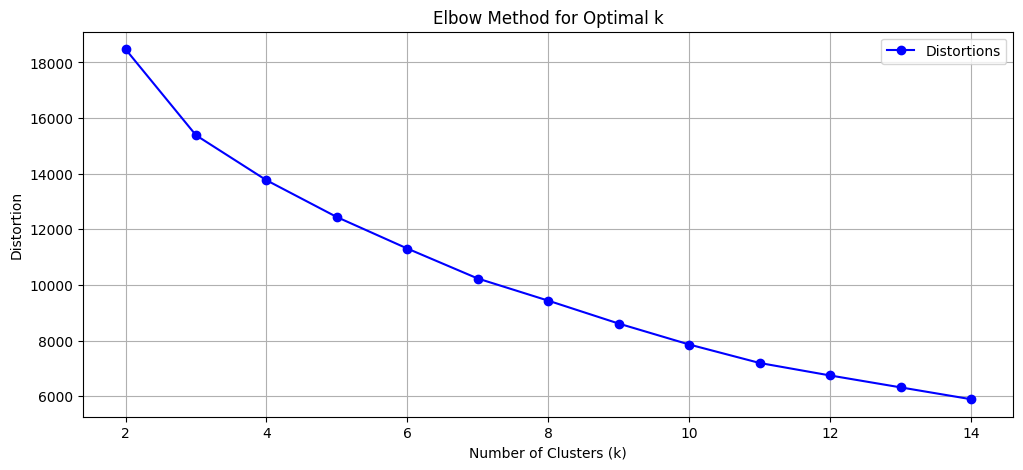

In [362]:
plt.figure(figsize=(12, 5))
plt.plot(n_clusters, distortions, marker='o', linestyle='-', color='b', label='Distortions')

plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.grid(True)
plt.legend()
plt.show()

analysing the elbow graph, we will use k=3 for number of clusters

In [363]:
km = KMeans(n_clusters=3, max_iter=10000, n_init=100, random_state=61658)
X_t = km.fit_predict(X)


In [364]:
df.loc[:, 'clus'] = X_t

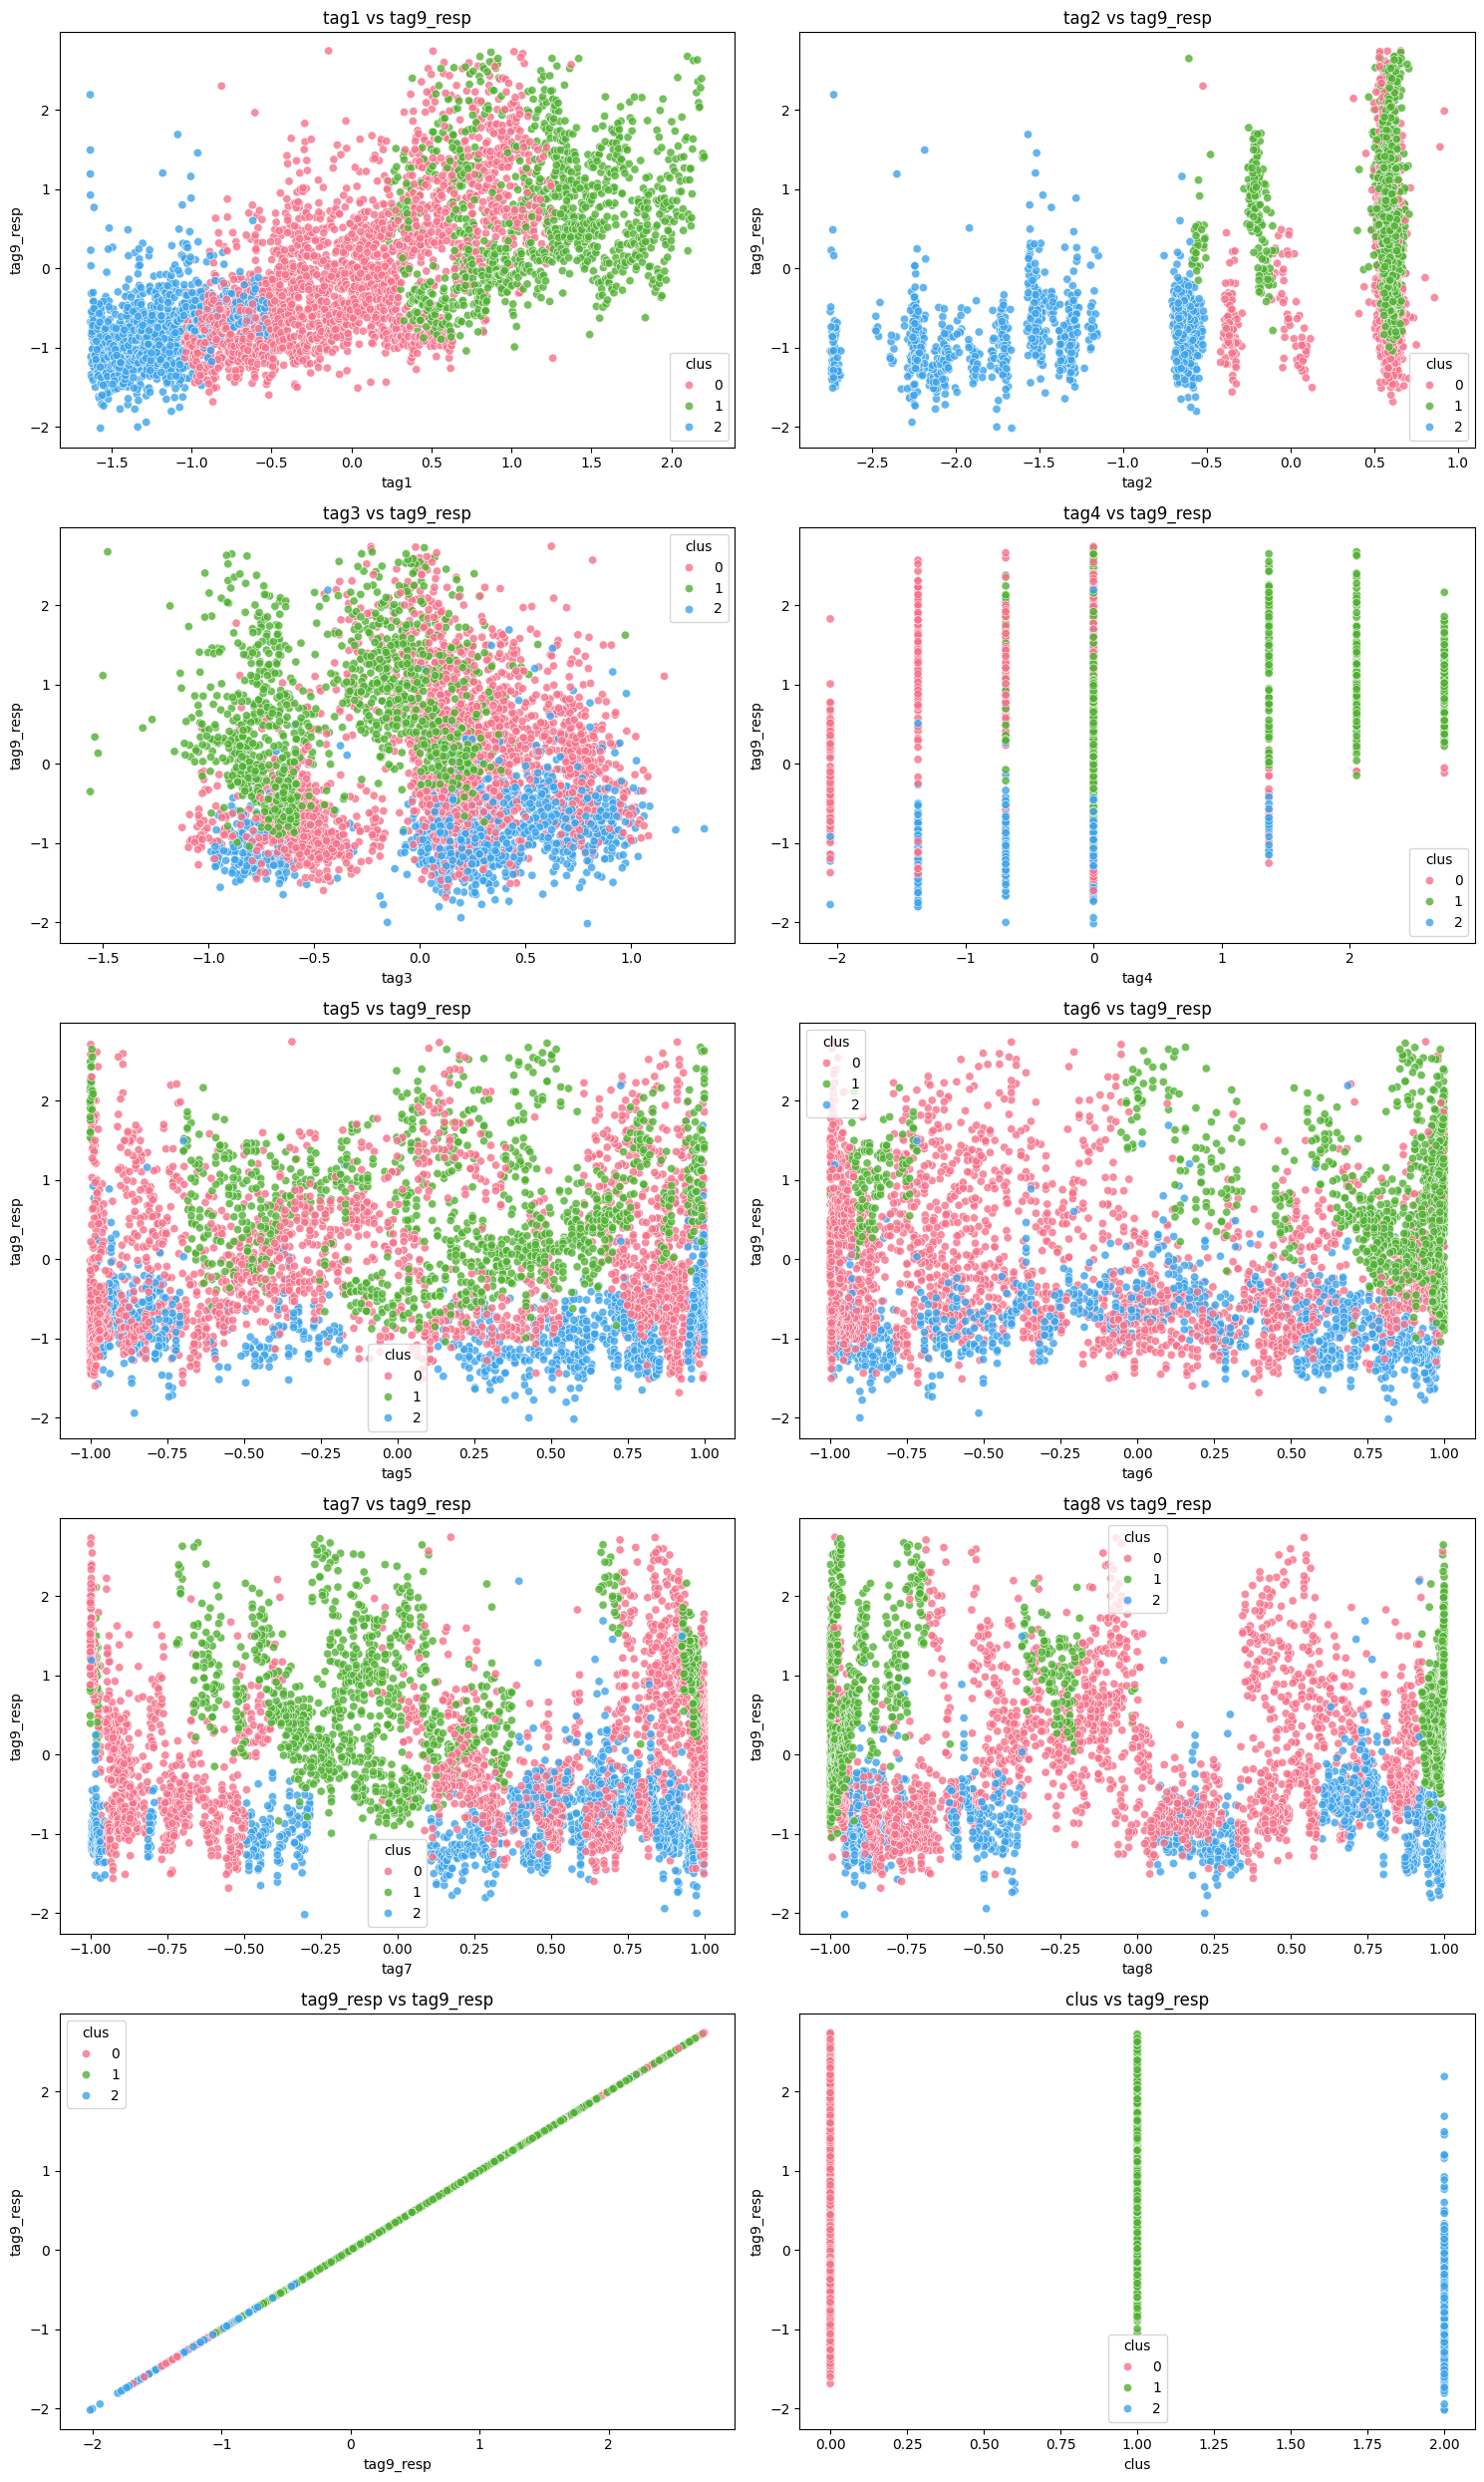

In [365]:
feature_columns = df.columns

# Set up the subplot grid
num_plots = len(feature_columns)
num_cols = 2  # You can adjust the number of columns based on your preference
num_rows = (num_plots - 1) // num_cols + 1

# Create a new figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Define a color palette
cluster_colors = sns.color_palette("husl", n_colors=len(df['clus'].unique()))

# Loop through each feature and create scatter plots
for i, feature in enumerate(feature_columns):
    sns.scatterplot(x=feature, y='tag9_resp', hue='clus', palette=cluster_colors, data=df, alpha=0.8, ax=axes[i])
    axes[i].set_title(f'{feature} vs tag9_resp')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('tag9_resp')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

As we can see in above graph, clustering separate tag9 variables in 3 groups:
- clus: 0: **average** values
- clus: 1: **high** values
- clus: 2: **low** values
---
So, lets check-out how the graph is distribuited without average values


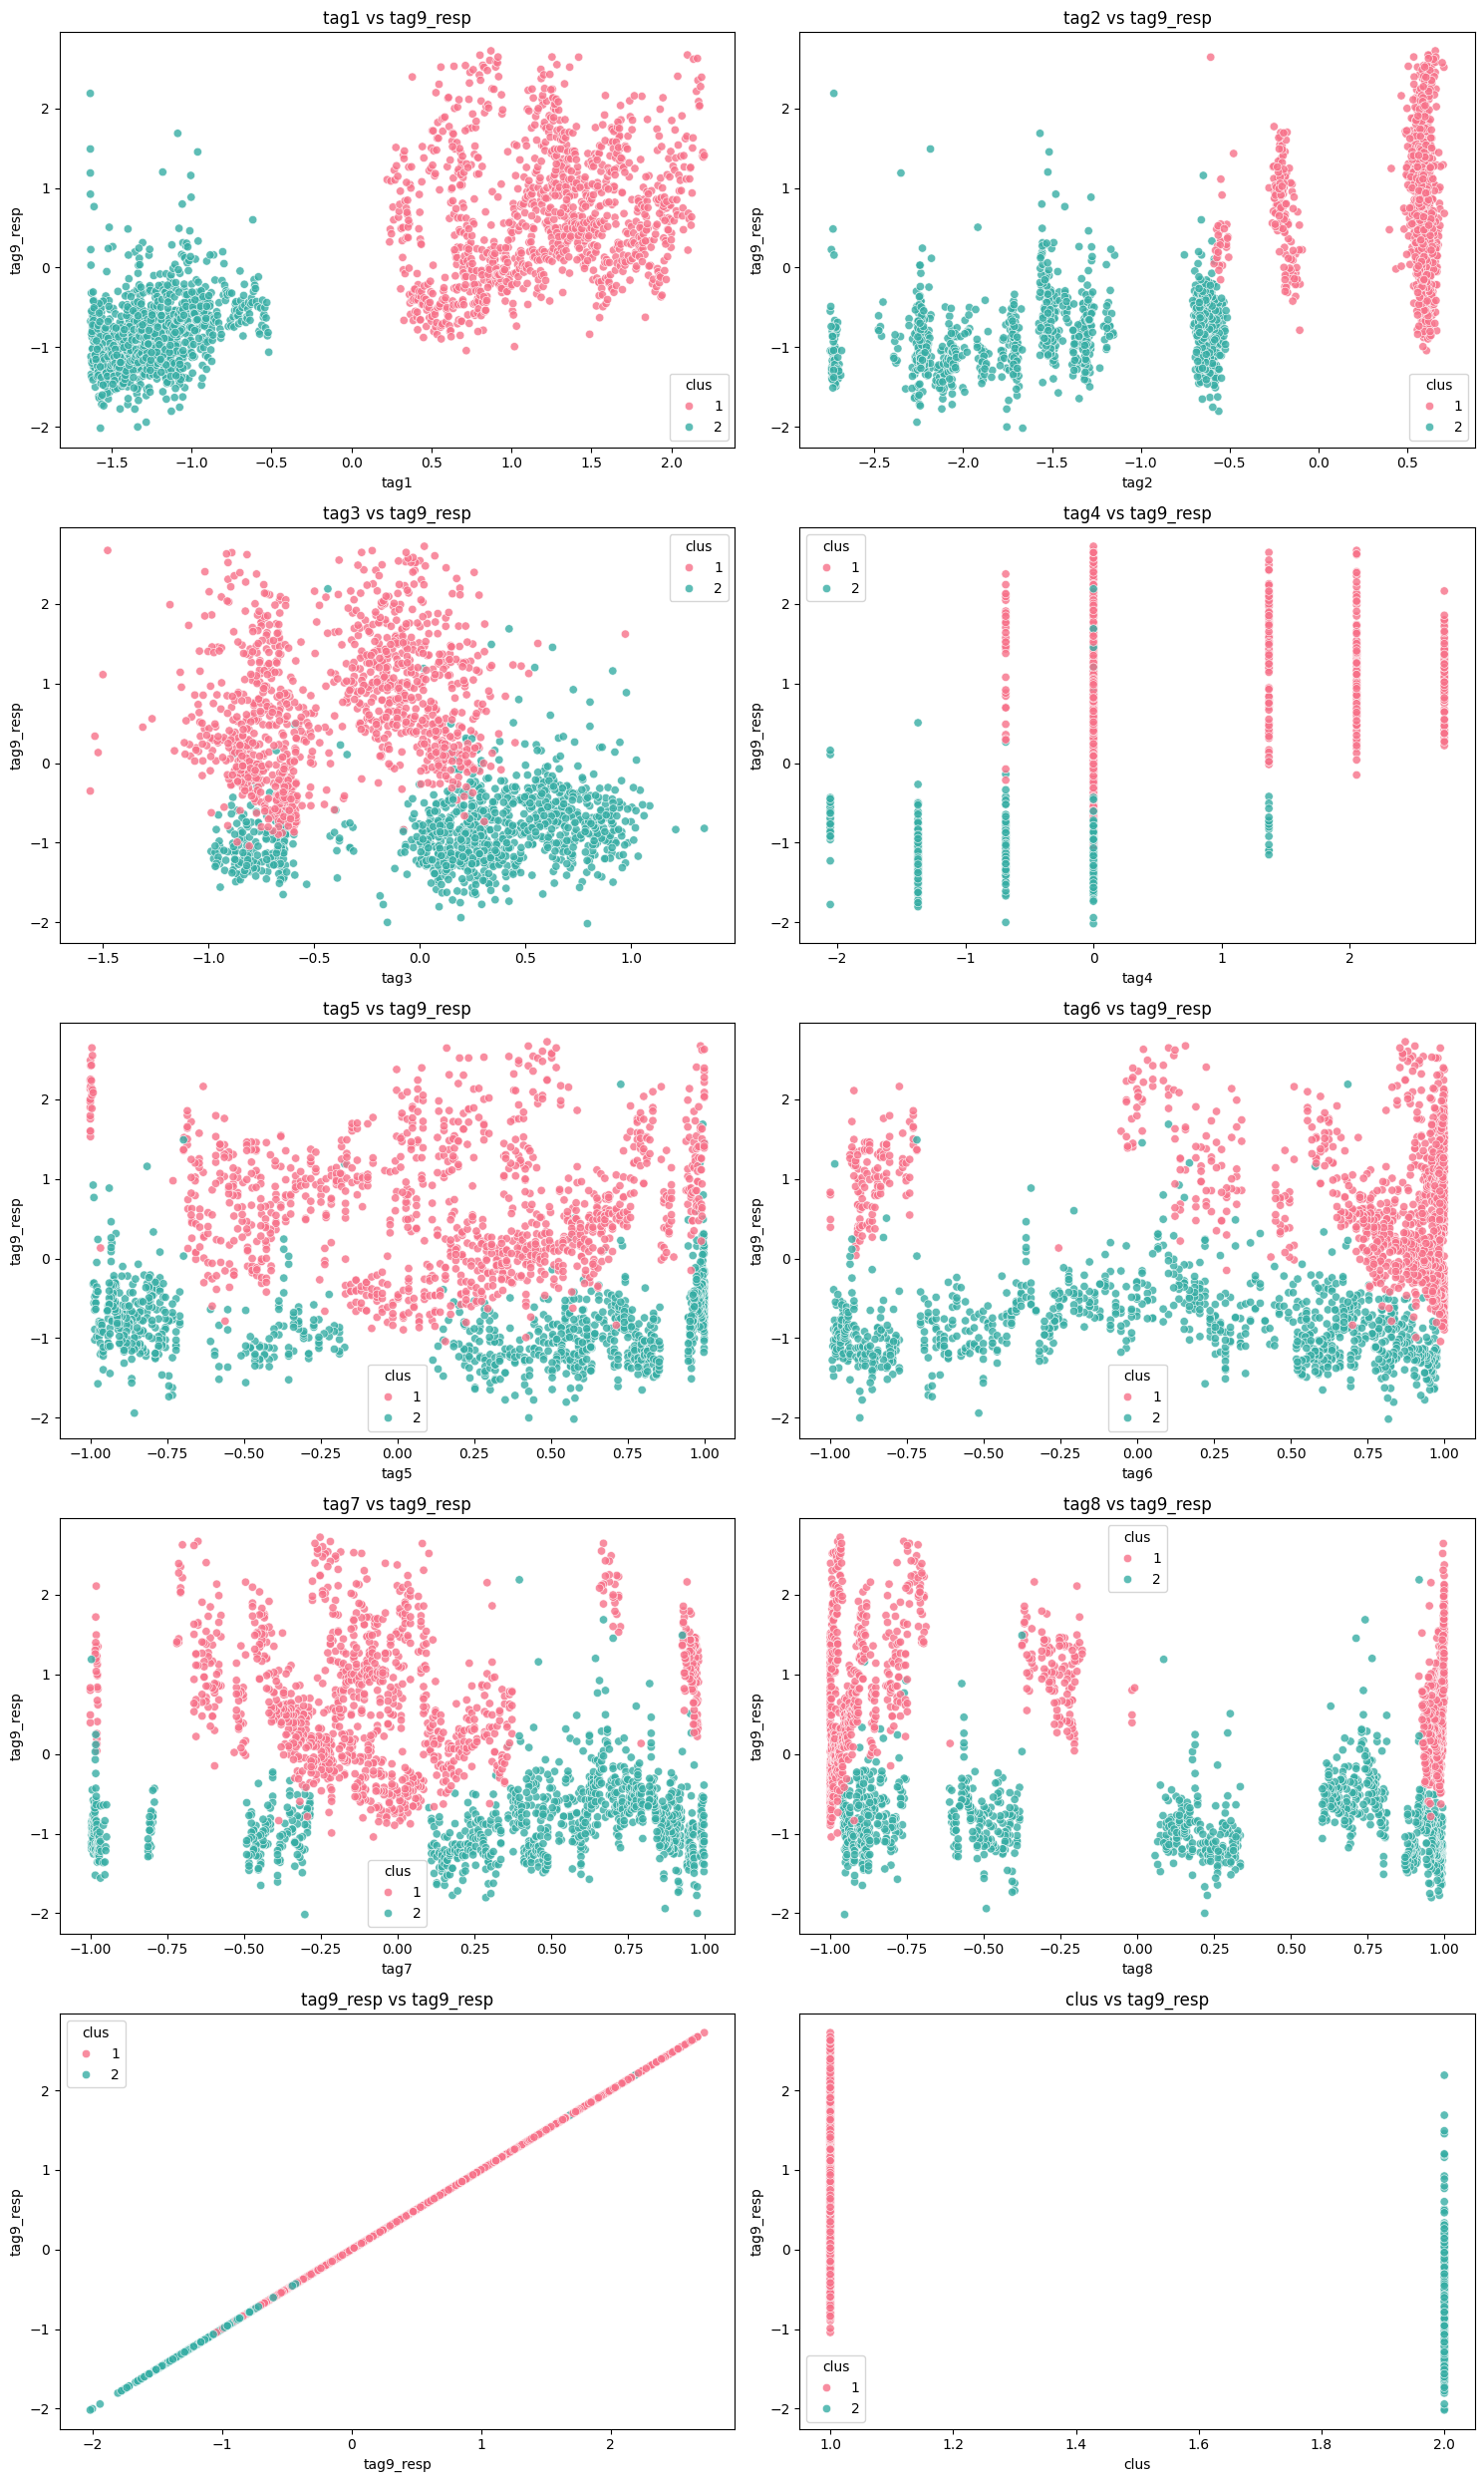

In [366]:
feature_columns = df.columns

# Set up the subplot grid
num_plots = len(feature_columns)
num_cols = 2  # You can adjust the number of columns based on your preference
num_rows = (num_plots - 1) // num_cols + 1

# Create a new figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Define a color palette
cluster_colors = sns.color_palette("husl", 2)

# Loop through each feature and create scatter plots
for i, feature in enumerate(feature_columns):
    sns.scatterplot(x=feature, y='tag9_resp', hue='clus', palette=cluster_colors, data=df[df['clus'] != 0], alpha=0.8, ax=axes[i])
    axes[i].set_title(f'{feature} vs tag9_resp')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('tag9_resp')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [367]:
df['clus'].value_counts()

clus
0    2300
1    1138
2    1048
Name: count, dtype: int64

now, we have 2 ways to separate your values:
- **alternative 1**: separate by k-means clusters
- **alternative 2**: separate by tag 9 values

## Part 4: training and choosing the best model for predictions

In [368]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf



In [369]:
tf.random.set_seed(42)

model = Sequential([
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1),
])
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['mse']
)

In [370]:
scaler = StandardScaler()


### try to predict values the df without clustering

In [371]:
df_full = df.drop('clus', axis=1).copy()

In [372]:
X = df_full.drop('tag9_resp', axis=1)
y = df_full['tag9_resp']

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

X_train_standart = scaler.fit_transform(X_train)
X_test_standart = scaler.transform(X_test)


In [374]:
history = model.fit(X_train_standart, y_train, epochs=200, verbose=0)

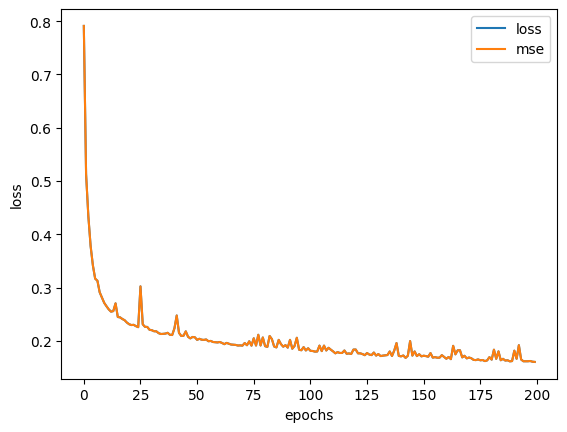

In [375]:
pd.DataFrame(history.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [376]:
m = model.evaluate(X_test_standart,y_test)
df_full = pd.DataFrame({'loss': [m[0]], 'mse': [m[1]]}, index=['Full'])

113/113 [==============================] - 1s 2ms/step - loss: 0.2549 - mse: 0.2549


try to predict higher and lower clusters

In [377]:
clusters = {0: 'Average', 1: 'Low' , 2: 'High', 3 : 'Mixed'}

In [378]:
results = []

def predict_values():
    for cluster,category in clusters.items():
        model = Sequential([
            layers.Dense(100, activation='relu'),
            layers.Dense(100, activation='relu'),
            layers.Dense(10, activation='relu'),
            layers.Dense(1),
        ])
        model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.SGD(),
            metrics=['mse']
        )

        df_category = df.copy()
        if category == 'Mixed':
            df_category = df_category[df_category['clus'] != 0]
        else :
            df_category = df_category[df_category['clus'] == cluster]

        df_category.drop('clus', axis=1, inplace=True)

        X = df_category.drop('tag9_resp', axis=1)
        y = df_category['tag9_resp']

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

        X_train_standart = scaler.fit_transform(X_train)
        X_test_standart = scaler.transform(X_test)
        
        model.fit(X_train_standart, y_train, epochs=200, verbose=0)

        results.append(model.evaluate(X_test_standart,y_test))
    return results
        
        
results = predict_values()


55/55 [==============================] - 0s 2ms/step - loss: 0.2363 - mse: 0.2363


In [379]:
df_result = pd.concat([
    pd.DataFrame({'loss': [result[0]], 'mse': [result[1]]}, index=[clusters[index]])
    for index, result in enumerate(results)
])
df_full = pd.concat([df_full, df_result])
df_full

loss       mse
Full     0.254906  0.254906
Average  0.227660  0.227660
Low      0.288009  0.288009
High     0.141507  0.141507
Mixed    0.236251  0.236251

## Conclusion

###  K-means tecnique improve considerably the predictions values for some group of clusters
K-means dont was a good method for predict **Low** values of tag9_resp. Maybe beacause of the **skewness** of this feature.  
however, i dont have enough knowledge to get insights from tag6 correlation with others bimodal variables

how to optimze predictions?
- **first**: reducing the p-value between tag9_resp and bimodal features.
- **second**: try to use others metrics for and layers to improve the model acurracy.
- **third**: use diferent models for diferent groups of clusters